# Autoregressive Model

In [29]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

## Prepare Data

## Import

In [2]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
lagos =db["lagos"]

Now since this is an autoregressive model I'll have to Change the wrangle function below so that it returns a Series of the resampled data instead of a DataFrame.

In [3]:
def wrangle(collection):
    results = collection.find(
        {"metadata.site": 3, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    # Read data into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Lagos")

    # Resample to 1hr window
    y = df["P2"].resample("1H").mean().fillna(method='ffill')

    return y

In [4]:
y = wrangle(lagos)
y.head()

timestamp
2018-10-01 01:00:00+01:00    0.010000
2018-10-01 02:00:00+01:00    0.010000
2018-10-01 03:00:00+01:00    0.010000
2018-10-01 04:00:00+01:00    0.010000
2018-10-01 05:00:00+01:00    3.147692
Freq: H, Name: P2, dtype: float64

## Explore

An ACF (Auto-Correlation Function) plot is a graph that represents the autocorrelation of a time series data. Autocorrelation refers to the degree of similarity between a given time series and a lagged version of itself.


The PACF plot is similar to the ACF plot, but it controls for the influence of earlier lags. Specifically, it shows the correlation between a time series and a lagged version of itself, controlling for the effect of all the other lags between them.


Next I'll Create an ACF plot for the data in y.

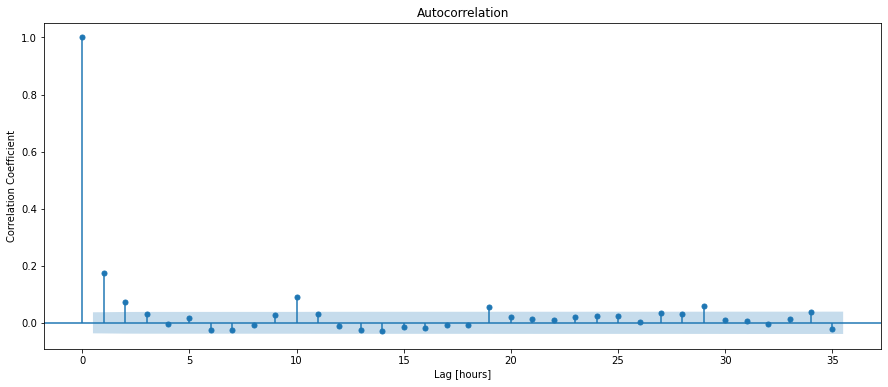

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

Now looking at  our viz let us check for significant correlation coefficients: Significant correlation coefficients are those that fall outside the dashed blue lines in the plot we can see that at hours at [1,10,19] are indications that there is a repeating pattern or seasonality in the data with these lag periods.

Next I'll create a PACF plot

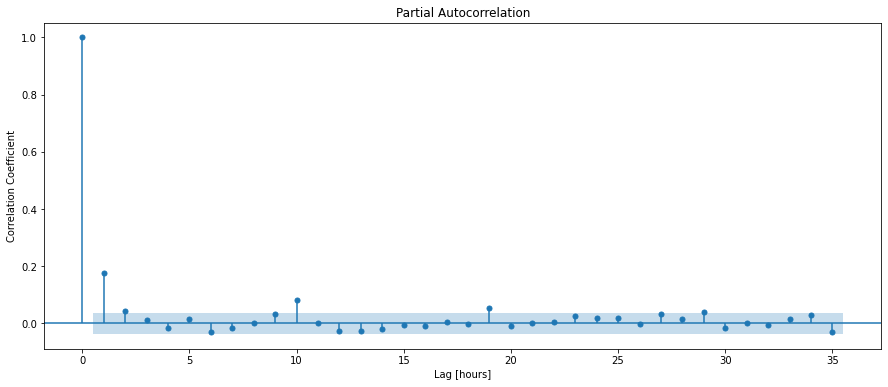

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

 significant correlation coefficients are those that fall outside the dashed blue lines in the plot, from the viz correlation coefficient  that are significantly different from zero,  suggests that the time series is correlated with its past lags at that lag value, controlling for the effects of intervening lags.

## Split

In [7]:
# Split y into training and test sets. The first 95% of the data is in my training set. The remaining 5% should is in the test set.
cutoff_test = int(len(y)*0.95)

y_train = y.iloc[:cutoff_test]
y_test =  y.iloc[cutoff_test:]

# Build Model

## Baseline

In [8]:
# Calculate the baseline mean absolute error for my model.
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 1.13
Baseline MAE: 1.45


##  Iterate

Autoregression (AR) is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. AR works in a similar way to autocorrelation: in both cases, we're taking data from one part of a set and comparing it to another part. An AR model regresses itself

Since I'm working with an AR model to predict PM2.5 readings, but which hyperparameter settings will give you the best performance?.I'll Use a for loop to train my AR model on using settings for p from 1 to 30. Each time the model is trains a new model, it will calculate its mean absolute error and append the result to the list maes.

In [9]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

# use  AR model to predict PM2.5 readings
# Hyperparameter (p)
p_params = range(1, 31)

maes = []
for p in p_params:
    #train model
    model = AutoReg(y_train, lags=p).fit()
    
    #generate in sample prediction
    y_pred = model.predict().dropna()
    #calculate mae
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)
    maes.append(mae)

mae_series = pd.Series(maes, index=p_params, name="mae")
mae_series.head()

1    1.389447
2    1.388181
3    1.388584
4    1.388708
5    1.387196
Name: mae, dtype: float64

Next I'll  Look through the results in mae_series and determine what value for p provides the best performance. Then build and train final_model using the best hyperparameter value.

In [10]:
best_p = mae_series.idxmin()
best_p

30

From the result above the best hyperparameter value (p) is 30. Then i'll build and train final_model using the best hyperparameter value. 

In [11]:
model = AutoReg(y_train,lags=30).fit()

In [12]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[30:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 1.366660236442696


In autoregressive (AR) models, residuals are the differences between the actual values of the time series and the predicted values of the AR model. In other words, residuals represent the part of the time series that is not explained by the AR model.


Next I'll  Use y_train and y_pred to calculate the residuals for your model.

In [13]:
y_train_resid = model.resid
y_train_resid.tail()

timestamp
2019-01-20 16:00:00+01:00   -0.870646
2019-01-20 17:00:00+01:00    9.902049
2019-01-20 18:00:00+01:00   -2.867792
2019-01-20 19:00:00+01:00   -1.305383
2019-01-20 20:00:00+01:00   -0.936532
Freq: H, dtype: float64

Next I'll Create a plot of y_train_resid

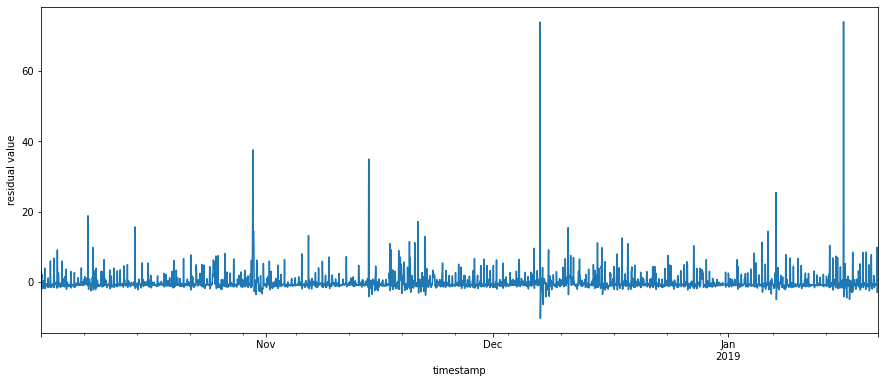

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="residual value",ax=ax);

Next I'll Create a histogram of y_train_resid

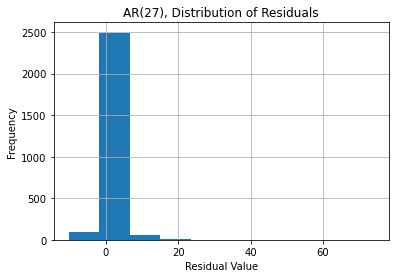

In [15]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(27), Distribution of Residuals");

Next I'll create an ACF plot of y_train_resid.

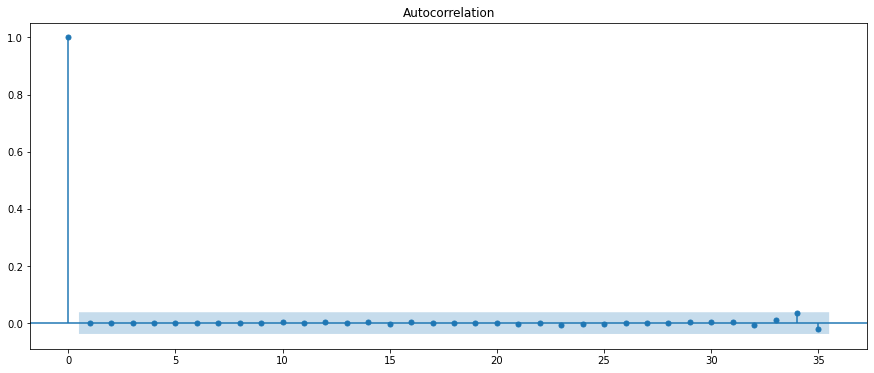

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax);

Next I'll  Calculate the test mean absolute error for your model.

In [17]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 1.4660357692257573


Now we can see that the above mae does not beat baseline. hence we carry out walk foward valuation.
The walk-forward validation approach is useful in time series modeling because it allows for a more accurate evaluation of the model's performance on new, unseen data 

Next I'll Perform walk-forward validation for my model for the entire test set y_test. Store your model's predictions in the Series y_pred_wfv.

In [25]:
y_pred_wfv = pd.Series(index=y_test.index, name="prediction")
history = y_train.copy()
lags = 30

for i in y_test.index:
    model = AutoReg(history, lags=lags).fit()
    y_pred = model.predict(start=len(history), end=len(history))
    y_pred_wfv.loc[i] = y_pred[0]
    history.loc[i] = y_test.loc[i]

y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2019-01-20 21:00:00+01:00    0.797423
2019-01-20 22:00:00+01:00    1.137733
2019-01-20 23:00:00+01:00    0.578306
2019-01-21 00:00:00+01:00    0.722144
2019-01-21 01:00:00+01:00    0.551356
Freq: H, Name: prediction, dtype: float64

In [26]:
# test mae
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.32


We can now agree that the test MAE(walk foward validation) beats the baseline .

# Communicate Results

Next I'll Put the values for y_test and y_pred_wfv into the DataFrame df_pred_test (don't forget the index). Then plot df_pred_test using plotly express

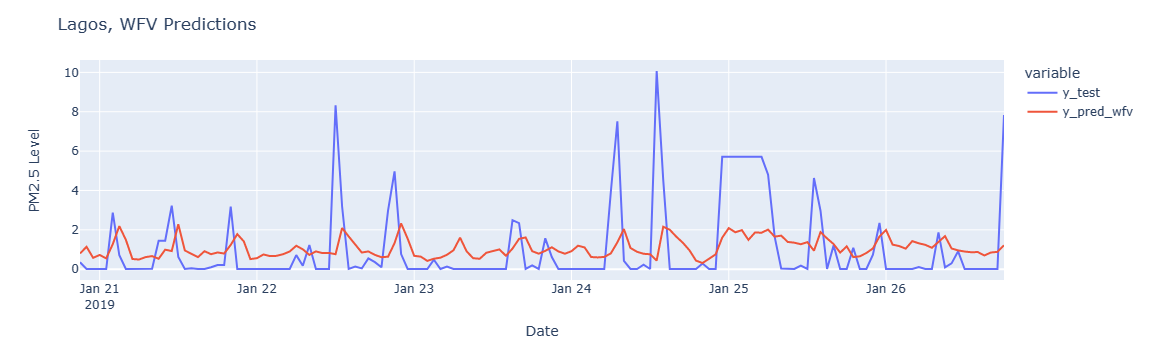

In [28]:
df_pred_test = pd.DataFrame(
            {"y_test": y_test, "y_pred_wfv": y_pred_wfv}

)
fig = px.line(df_pred_test, labels={"value"})
fig.update_layout(
    title="Lagos, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)

From the above visualization we can see that there is no so much disparity between the test and the predicted values.